In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
from sklearn import neural_network
from sklearn.model_selection import cross_val_score
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Sebastito/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Data import

In [2]:
# Loading data from source
high = pd.read_csv('data/highp_finalresults.csv')
low = pd.read_csv('data/lowp_finalresults.csv')
high.head()

,ident,it,t,a(i),emegas(i),emepla(i)/emet,rplanet(i)/radtie,emestar,rc,qest,sigmag_0,emed,gama,apert,fpert,constmigI,emetal,taugas
0,0,199993,20000001,0.030237,0.004911,1.904923,1.9029824602178687,4.368174e+32,59.88237,1.110726,51.287674,0.13,1,0.3,1,0.1,0.07707,9268935
1,0,199993,20000001,0.818832,0.000238,1.642056,1.8150047639338782,4.368174e+32,59.88237,1.110726,51.287674,0.13,1,0.3,1,0.1,0.07707,9268935
2,0,199993,20000001,2.124022,0.000000,1.786051,1.8659921485803184,4.368174e+32,59.88237,1.110726,51.287674,0.13,1,0.3,1,0.1,0.07707,9268935
3,0,199993,20000001,5.123330,0.000000,0.843418,1.4538852266916131,4.368174e+32,59.88237,1.110726,51.287674,0.13,1,0.3,1,0.1,0.07707,9268935
4,0,199993,20000001,6.932367,0.000000,0.477013,1.2031125383842882,4.368174e+32,59.88237,1.110726,51.287674,0.13,1,0.3,1,0.1,0.07707,9268935


In [3]:
high.describe()

,ident,it,t,a(i),emegas(i),emepla(i)/emet,emestar,rc,qest,sigmag_0,emed,gama,apert,fpert,constmigI,emetal,taugas
count,32465.000000,32465.000000,32465,32465.000000,3.246500e+04,32465.000000,3.246500e+04,32465.000000,32465.000000,32465.000000,32465.000000,32465,32465.0,32465,3.246500e+04,32465.000000,32465.000000
mean,1483.424457,197467.410966,20000001,3.400574,7.167241e+00,7.630333,5.749874e+32,45.545752,5.963431,32.194985,0.043325,1,0.3,1,1.000000e-01,-0.001367,3801386.541862
std,859.799152,8122.269582,0,3.696724,2.198142e+02,219.589599,2.784088e+32,8.270644,4.245843,33.406671,0.039576,0,0.0,0,1.871346e-09,0.211647,2503499.813300
min,0.000000,9292.000000,20000001,0.002813,0.000000e+00,0.050002,2.005149e+32,25.340290,1.007152,1.515903,0.003100,1,0.3,1,1.000000e-01,-0.688720,1001011.375000
25%,739.000000,198311.000000,20000001,0.913345,0.000000e+00,0.098376,3.379212e+32,39.816555,2.955550,12.484508,0.019000,1,0.3,1,1.000000e-01,-0.145420,1687664.250000
50%,1484.000000,199620.000000,20000001,2.140342,0.000000e+00,0.229774,5.161603e+32,44.740940,4.808668,21.058982,0.030000,1,0.3,1,1.000000e-01,0.000306,2998146.500000
75%,2227.000000,199907.000000,20000001,4.670935,2.295691e-10,0.669832,7.774028e+32,50.544758,7.681329,39.672398,0.054000,1,0.3,1,1.000000e-01,0.143216,5405266.000000
max,2974.000000,199999.000000,20000001,37.368091,1.963193e+04,19634.764964,1.198218e+33,91.153824,48.223476,372.454042,0.320000,1,0.3,1,1.000000e-01,0.774710,9985367.000000


## Data handling 

---

Data are organized in such way that each observation represent a formed planet. We have to collapse data by planetary systems ($ident$). However, before do this we should verify that variables don't have variation between systems. At the end, we must create the final variables to predict:

Variables:

    1. Number of planets.
    2. Planets total mass.
    3. Mass efficiency.

Tasks:
    1. Create final variables.
    2. Collapse data by $ident$

### Non-Relevant variables

There are several variables in each dataFrame that don't give extra information because those don't have variance over the set, for example:
    
    1. t.
    2. gama.
    3. fpert.
    4. constmigI.
    
So we can drop them. Futhermore, we can ignore $ident$ information because system identifier should not give any information about the dependet variables.

----

In the case of the variable $apert$ we have no variation inside sets but variation between groups (high & low). It should be usuful to check if this variable has effect over the dependent variables in order to include $apert$ as a relevant varaible to explain planetary formation. 

As the sets are divided by $apert$ we have to check if there is a statistical difference over the dependent variables. In order to do that we will use sampling techniques to verify this hypotesis. 

In [4]:
def collapse_by_system(dataFrame):
    ident_systems = np.unique(dataFrame['ident'])
    num_systems = len(ident_systems)
    print('There is only '+ str(num_systems),'non-empty observations (systems).')
    dataFrame_systems = pd.DataFrame(np.nan, index = range(0,0), columns = dataFrame.columns ) 

    num_planets = np.zeros(num_systems)
    solid_mass = np.zeros(num_systems)
    mass_efficiency = np.zeros(num_systems)
    for sys in range(0,num_systems):
        system = ident_systems[sys]
        actual = dataFrame[dataFrame['ident'] == system]
        num_planets[sys] = actual['ident'].count()
        solid_mass[sys] = sum(actual['emepla(i)/emet'])
        mass_efficiency[sys] = solid_mass[sys]/np.min(actual['emed'])
        dataFrame_systems.loc[sys,:] = actual.iloc[0,:]
    
    dataFrame_systems['num_planets'] = num_planets
    dataFrame_systems['solid_mass'] = solid_mass
    dataFrame_systems['mass_efficiency'] = mass_efficiency
    
    Y_dataFrame = dataFrame_systems[['num_planets','solid_mass','mass_efficiency']]
    X_dataFrame = dataFrame_systems[['it', 'emestar', 'rc', 'qest', 'sigmag_0', 'emed', 'apert', 'emetal','taugas']]
    return X_dataFrame, Y_dataFrame

In [5]:
X_high,Y_high = collapse_by_system(high)

('There is only 2770', 'non-empty observations (systems).')


In [6]:
X_low,Y_low = collapse_by_system(low)

('There is only 2735', 'non-empty observations (systems).')


In [7]:
# Save new data
X_low.to_csv('data/X_low.csv',index = False)
Y_low.to_csv('data/Y_low.csv',index = False)
X_high.to_csv('data/X_high.csv',index = False)
Y_high.to_csv('data/Y_high.csv',index = False)

# Import data with numpy

In [8]:
from sklearn import svm
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [9]:
X_low=np.genfromtxt('data/X_low.csv', delimiter=',', dtype='float', skip_header=1)
Y_low=np.genfromtxt('data/Y_low.csv', delimiter=',', dtype='float', skip_header=1)
X_high=np.genfromtxt('data/X_high.csv', delimiter=',', dtype='float', skip_header=1)
Y_high=np.genfromtxt('data/Y_high.csv', delimiter=',', dtype='float', skip_header=1)
X_low=np.delete(X_low, 6, axis=1)
X_high=np.delete(X_high, 6, axis=1)

In [10]:
scax_low = sk.preprocessing.StandardScaler().fit(X_low)
scax_high = sk.preprocessing.StandardScaler().fit(X_high)
scay_low = sk.preprocessing.StandardScaler().fit(Y_low)
scay_high = sk.preprocessing.StandardScaler().fit(Y_high)

X_low=scax_low.transform(X_low)
X_high=scax_high.transform(X_high)
Y_low=scay_low.transform(Y_low)
Y_high=scay_high.transform(Y_high)

# Regularization-Low (Punto 2)

# Correspondance between attribute number/value
 0 -> Iteration index. 
 1 -> Stellar mass.
 2 -> Disk outer cutoff radius.
 3 -> Toomre Q at min radius.
 4 -> Maximum dust surface density.
 5 -> Disk mass.
 6 -> Metallicity wrt solar.
 7 -> Gas dissipation timescale.

In [11]:
from sklearn import linear_model
from sklearn.metrics import r2_score

In [12]:
def relative_importance(coefs):
    coe=np.abs(coefs)
    tot=float(np.sum(coe))
    for i in range(len(coe)):
        donde=np.where(coe==np.max(coe))[0][0]
        imp=coe[donde]/tot *100
        print "El atributo " + str(donde) + ". Tiene importancia relativa de: " + str(round(imp,2)) + "%"
        coe[donde]=-1

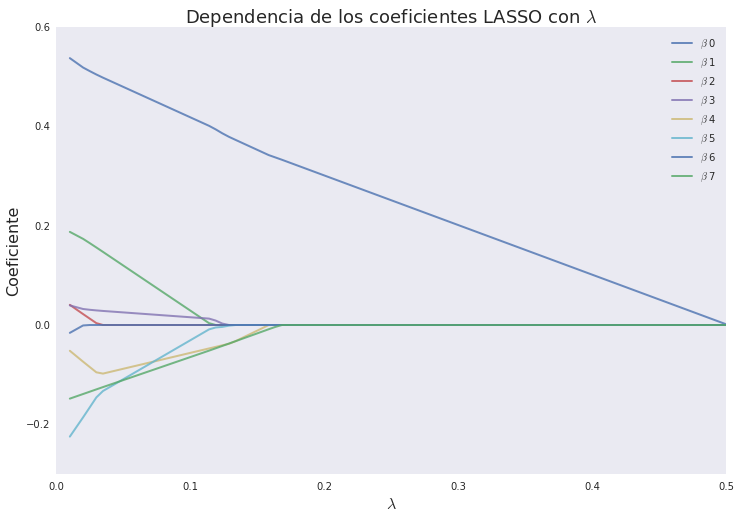

Para la prediccion de numero de planetas para sistemas con baja perturbacion (lambda = 0.01): 

El atributo 0. Tiene importancia relativa de: 43.14%
El atributo 5. Tiene importancia relativa de: 18.04%
El atributo 1. Tiene importancia relativa de: 15.05%
El atributo 7. Tiene importancia relativa de: 11.9%
El atributo 4. Tiene importancia relativa de: 4.17%
El atributo 2. Tiene importancia relativa de: 3.26%
El atributo 3. Tiene importancia relativa de: 3.17%
El atributo 6. Tiene importancia relativa de: 1.27%


In [13]:
N=100
L=0.5
matrix = np.zeros((8,N))
alphas = np.linspace(0.01,L,N)

for i in range(len(alphas)):
    clf = linear_model.Lasso(alpha=alphas[i])
    clf.fit(X_low, Y_low[:,0])
    matrix[:,i]=clf.coef_

plt.figure(figsize=(12,8))
for j in range(8):
    plt.plot(alphas, matrix[j,:], lw=2, alpha=0.8, label=r"$\beta $ "+str(j))
plt.legend(framealpha=0.5)
plt.grid()
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel(r"Coeficiente", fontsize=16)
plt.title(r"Dependencia de los coeficientes LASSO con $\lambda$", fontsize=18)
plt.show()
plt.close()

print "Para la prediccion de numero de planetas para sistemas con baja perturbacion (lambda = 0.01): \n"
relative_importance(matrix[:,0])

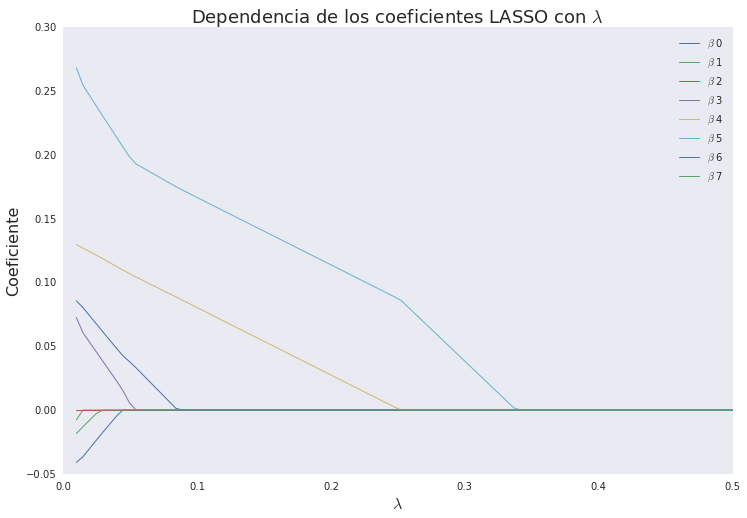

Para la prediccion de masa total para sistemas con baja perturbacion (lambda = 0.01): 

El atributo 5. Tiene importancia relativa de: 43.04%
El atributo 4. Tiene importancia relativa de: 20.81%
El atributo 6. Tiene importancia relativa de: 13.73%
El atributo 3. Tiene importancia relativa de: 11.63%
El atributo 0. Tiene importancia relativa de: 6.59%
El atributo 7. Tiene importancia relativa de: 2.95%
El atributo 1. Tiene importancia relativa de: 1.23%
El atributo 2. Tiene importancia relativa de: 0.0%


In [14]:
for i in range(len(alphas)):
    clf = linear_model.Lasso(alpha=alphas[i])
    clf.fit(X_low, Y_low[:,1])
    matrix[:,i]=clf.coef_

plt.figure(figsize=(12,8))
for j in range(8):
    plt.plot(alphas, matrix[j,:], lw=1, label=r"$\beta$ "+str(j))
plt.legend(framealpha=0.5)
plt.grid()
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel(r"Coeficiente", fontsize=16)
plt.title(r"Dependencia de los coeficientes LASSO con $\lambda$", fontsize=18)
plt.show()
plt.close()

print "Para la prediccion de masa total para sistemas con baja perturbacion (lambda = 0.01): \n"
relative_importance(matrix[:,0])

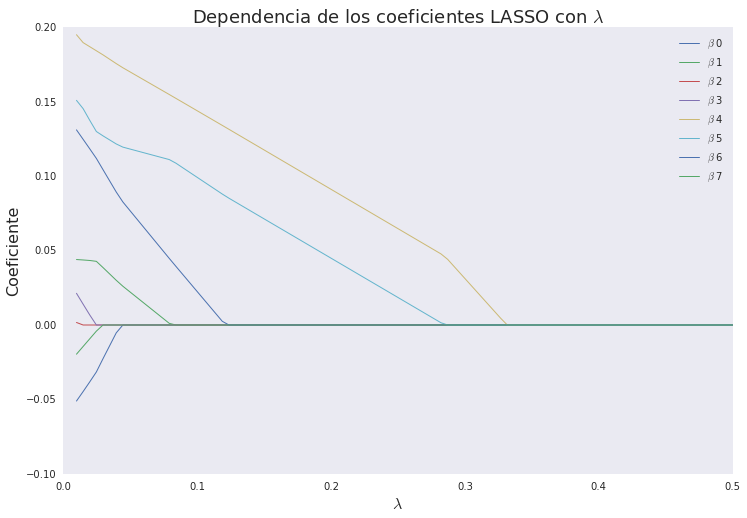

Para la prediccion de la eficiencia de masa para sistemas con baja perturbacion (lambda = 0.01): 

El atributo 4. Tiene importancia relativa de: 31.73%
El atributo 5. Tiene importancia relativa de: 24.55%
El atributo 6. Tiene importancia relativa de: 21.33%
El atributo 0. Tiene importancia relativa de: 8.31%
El atributo 1. Tiene importancia relativa de: 7.15%
El atributo 3. Tiene importancia relativa de: 3.46%
El atributo 7. Tiene importancia relativa de: 3.19%
El atributo 2. Tiene importancia relativa de: 0.28%


In [15]:
for i in range(len(alphas)):
    clf = linear_model.Lasso(alpha=alphas[i])
    clf.fit(X_low, Y_low[:,2])
    matrix[:,i]=clf.coef_

plt.figure(figsize=(12,8))
for j in range(8):
    plt.plot(alphas, matrix[j,:], lw=1, label=r"$\beta $ "+str(j))
plt.legend(framealpha=0.5)
plt.grid()
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel(r"Coeficiente", fontsize=16)
plt.title(r"Dependencia de los coeficientes LASSO con $\lambda$", fontsize=18)
plt.show()
plt.close()

print "Para la prediccion de la eficiencia de masa para sistemas con baja perturbacion (lambda = 0.01): \n"
relative_importance(matrix[:,0])

# Regularization-High

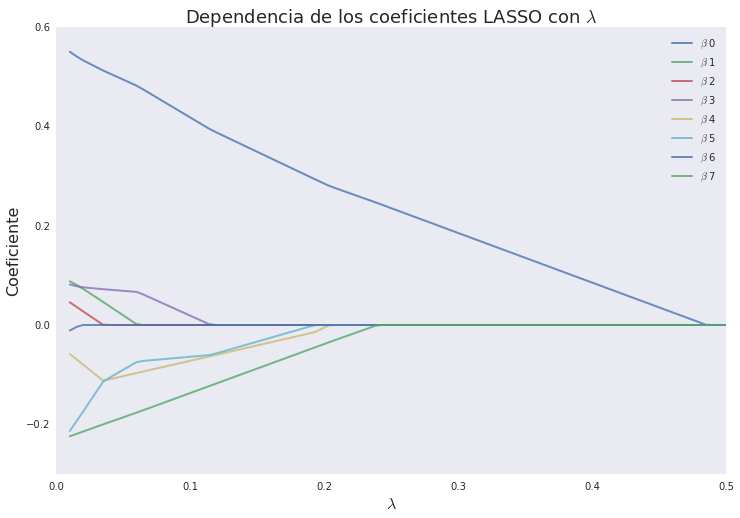

Para la prediccion de numero de planetas para sistemas con alta perturbacion (lambda = 0.01): 

El atributo 0. Tiene importancia relativa de: 43.25%
El atributo 7. Tiene importancia relativa de: 17.61%
El atributo 5. Tiene importancia relativa de: 16.76%
El atributo 1. Tiene importancia relativa de: 6.91%
El atributo 3. Tiene importancia relativa de: 6.41%
El atributo 4. Tiene importancia relativa de: 4.59%
El atributo 2. Tiene importancia relativa de: 3.59%
El atributo 6. Tiene importancia relativa de: 0.87%


In [16]:
for i in range(len(alphas)):
    clf = linear_model.Lasso(alpha=alphas[i])
    clf.fit(X_high, Y_high[:,0])
    matrix[:,i]=clf.coef_

plt.figure(figsize=(12,8))
for j in range(8):
    plt.plot(alphas, matrix[j,:], lw=2, alpha=0.8, label=r"$\beta $ "+str(j))
plt.legend(framealpha=0.5)
plt.grid()
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel(r"Coeficiente", fontsize=16)
plt.title(r"Dependencia de los coeficientes LASSO con $\lambda$", fontsize=18)
plt.show()
plt.close()

print "Para la prediccion de numero de planetas para sistemas con alta perturbacion (lambda = 0.01): \n"
relative_importance(matrix[:,0])

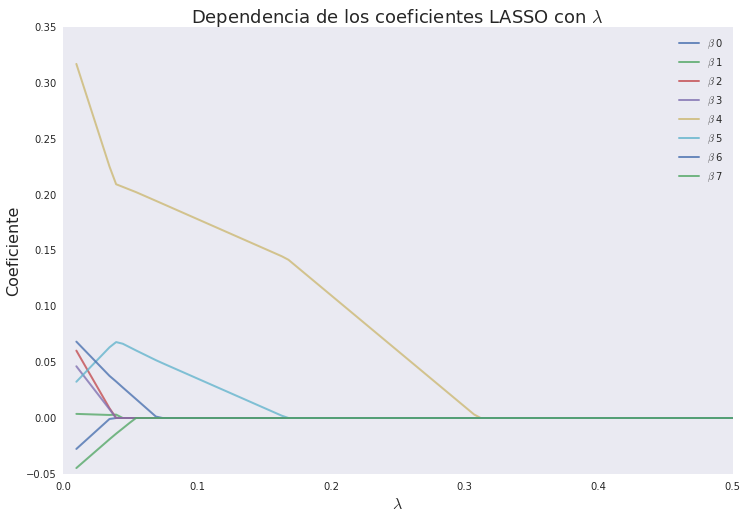

Para la prediccion de masa total para sistemas con alta perturbacion (lambda = 0.01): 

El atributo 4. Tiene importancia relativa de: 52.78%
El atributo 6. Tiene importancia relativa de: 11.38%
El atributo 2. Tiene importancia relativa de: 10.04%
El atributo 3. Tiene importancia relativa de: 7.71%
El atributo 7. Tiene importancia relativa de: 7.46%
El atributo 5. Tiene importancia relativa de: 5.4%
El atributo 0. Tiene importancia relativa de: 4.61%
El atributo 1. Tiene importancia relativa de: 0.61%


In [17]:
for i in range(len(alphas)):
    clf = linear_model.Lasso(alpha=alphas[i])
    clf.fit(X_high, Y_high[:,1])
    matrix[:,i]=clf.coef_

plt.figure(figsize=(12,8))
for j in range(8):
    plt.plot(alphas, matrix[j,:], lw=2, alpha=0.8, label=r"$\beta $ "+str(j))
plt.legend(framealpha=0.5)
plt.grid()
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel(r"Coeficiente", fontsize=16)
plt.title(r"Dependencia de los coeficientes LASSO con $\lambda$", fontsize=18)
plt.show()
plt.close()

print "Para la prediccion de masa total para sistemas con alta perturbacion (lambda = 0.01): \n"
relative_importance(matrix[:,0])

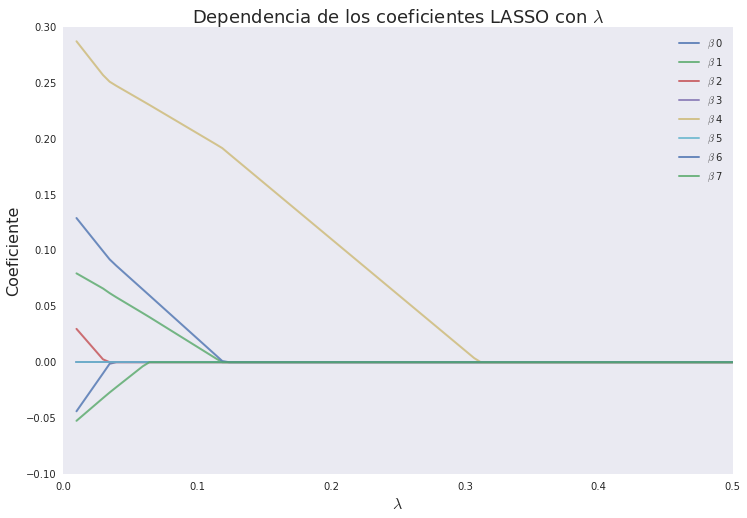

Para la prediccion de la eficiencia de masa para sistemas con baja perturbacion (lambda = 0.01): 

El atributo 4. Tiene importancia relativa de: 46.18%
El atributo 6. Tiene importancia relativa de: 20.74%
El atributo 1. Tiene importancia relativa de: 12.78%
El atributo 7. Tiene importancia relativa de: 8.43%
El atributo 0. Tiene importancia relativa de: 7.06%
El atributo 2. Tiene importancia relativa de: 4.8%
El atributo 3. Tiene importancia relativa de: 0.0%
El atributo 5. Tiene importancia relativa de: 0.0%


In [18]:
for i in range(len(alphas)):
    clf = linear_model.Lasso(alpha=alphas[i])
    clf.fit(X_high, Y_high[:,2])
    matrix[:,i]=clf.coef_

plt.figure(figsize=(12,8))
for j in range(8):
    plt.plot(alphas, matrix[j,:], lw=2, alpha=0.8, label=r"$\beta $ "+str(j))
plt.legend(framealpha=0.5)
plt.grid()
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel(r"Coeficiente", fontsize=16)
plt.title(r"Dependencia de los coeficientes LASSO con $\lambda$", fontsize=18)
plt.show()
plt.close()

print "Para la prediccion de la eficiencia de masa para sistemas con baja perturbacion (lambda = 0.01): \n"
relative_importance(matrix[:,0])

# Punto 1

# Train, test, and validation test preparation

In [19]:
from sklearn.preprocessing import PolynomialFeatures

X_low_train, X_low_val, Y_low_train, Y_low_val = train_test_split(X_low, Y_low, train_size=0.80, random_state=1)
X_low_train, X_low_test, Y_low_train, Y_low_test = train_test_split(X_low_train, Y_low_train, train_size=0.80, random_state=2)

X_high_train, X_high_val, Y_high_train, Y_high_val = train_test_split(X_high, Y_high, train_size=0.80, random_state=3)
X_high_train, X_high_test, Y_high_train, Y_high_test = train_test_split(X_high_train, Y_high_train, train_size=0.80, random_state=4)

# Polynomial fit

In [20]:
def ajuste_poli(X_train, X_test, Y_train, Y_test, alfa, grado):
    poly = PolynomialFeatures(degree=grado)
    X_high_train_trans=poly.fit_transform(X_train)
    X_high_test_trans=poly.fit_transform(X_test)

    clf=linear_model.Lasso(alpha=alfa)
    clf.fit(X_high_train_trans, Y_train)
    
    return clf.score(X_high_test_trans, Y_test)

In [21]:
#Planetas-Low
print "Numero de planetas. Perturbacion baja:"
print "r^2="+str(round(ajuste_poli(X_low_train, X_low_test, Y_low_train[:,0], Y_low_test[:,0], 0.0001, 3),2))
#Masa total-Low
print "Masa total. Perturbacion baja:"
print "r^2="+ str(round(ajuste_poli(X_low_train, X_low_test, Y_low_train[:,1], Y_low_test[:,1], 0.0001, 2),2))
#Eficiencia-Low
print "Eficiencia de masa. Perturbacion baja:"
print "r^2="+ str(round(ajuste_poli(X_low_train, X_low_test, Y_low_train[:,2], Y_low_test[:,2], 0.0001, 2),2))
#Planetas-High
print "Numero de planetas. Perturbacion alta:"
print "r^2="+ str(round(ajuste_poli(X_high_train, X_high_test, Y_high_train[:,0], Y_high_test[:,0], 0.0001, 3),2))
#Masa total-High
print "Masa total. Perturbacion alta:"
print "r^2="+ str(round(ajuste_poli(X_high_train, X_high_test, Y_high_train[:,1], Y_high_test[:,1], 0.0001, 2),2))
#Eficiencia-High
print "Eficiencia de masa. Perturbacion alta:"
print "r^2="+ str(round(ajuste_poli(X_high_train, X_high_test, Y_high_train[:,2], Y_high_test[:,2], 0.0001, 2),2))

Numero de planetas. Perturbacion baja:


/Users/Sebastito/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


r^2=0.54
Masa total. Perturbacion baja:
r^2=0.11
Eficiencia de masa. Perturbacion baja:
r^2=0.16
Numero de planetas. Perturbacion alta:
r^2=0.64
Masa total. Perturbacion alta:
r^2=-0.06
Eficiencia de masa. Perturbacion alta:
r^2=0.04


# Random Forest classification (alternative method)

In [22]:
def fix(Y_fix):
    Y_fix[:,0]= Y_fix[:,0]//3
    
    Y_fix[:,1]=Y_fix[:,1]//1
    for i in range(len(Y_fix[:,1])):
        if Y_fix[i,1]>=10 and Y_fix[i,1]<=100:
            Y_fix[i,1]=Y_fix[i,1]//10*10
        elif Y_fix[i,1]>100 and Y_fix[i,1]<=1000:
            Y_fix[i,1]=Y_fix[i,1]//100*100
        elif Y_fix[i,1]>1000:
            Y_fix[i,1]=Y_fix[i,1]//1000*1000
            
    Y_fix[:,2]=Y_fix[:,2]//10
    for i in range(len(Y_fix[:,2])):
        if Y_fix[i,2]>=20 and Y_fix[i,2]<=100:
            Y_fix[i,2]=Y_fix[i,2]//10*10
        elif Y_fix[i,2]>100 and Y_fix[i,2]<=1000:
            Y_fix[i,2]=Y_fix[i,2]//100*100
        elif Y_fix[i,2]>1000:
            Y_fix[i,2]=Y_fix[i,2]//1000*1000

In [23]:
def forest(n_trees, prof, feat, X_train, Y_train, X_test, Y_test, print_mat):
    rf = RandomForestClassifier(n_estimators=n_trees, max_depth=prof, max_features=feat)
    rf.fit(X_train, Y_train)

    y_predict = rf.predict(X_test)
    matrix=confusion_matrix(Y_test, y_predict)
    return float(matrix.trace())/np.sum(matrix)

In [24]:
def explore_params(trees, profund, features, X_train, Y_train, X_test, Y_test):
    best_tree=0.0
    best_depth=0.0
    best_atrib=0.0
    hits=0.0
    for i in range(len(trees)):
        for j in range(len(profund)):
            for k in range(len(features)):
                temp=forest(trees[i], profund[j], features[k], X_train, Y_train, X_test, Y_test, 0)
                if temp>hits:
                    best_tree=trees[i]
                    best_depth=profund[j]
                    best_atrib=features[k]
                    hits=temp
    print "Porcentaje de aciertos = " + str(round(temp*100.0,2))
    return best_tree, best_depth, best_atrib

In [25]:
def importancia(tree, depth, feature, X_train, Y_train):
    rf = RandomForestClassifier(n_estimators=tree, max_depth=depth, max_features=feature)
    rf.fit(X_train, Y_train)
    atributo=[]
    importance=[]
    ii = np.argsort(rf.feature_importances_)
    for i in range(1,len(X_train[0,:])+1):
        atributo.append(ii[-1*i])
        importance.append(rf.feature_importances_[ii[-1*i]])
        print "Atributo: ", ii[-1*i], ". Importancia relativa: ", rf.feature_importances_[ii[-1*i]]
    return atributo, importance

In [26]:
arboles=np.arange(1, 122, 30)
depths=np.arange(1, 100, 10)
atrib=np.arange(1, 8, 1)

In [27]:
X_low=np.genfromtxt('data/X_low.csv', delimiter=',', dtype='float', skip_header=1)
Y_low=np.genfromtxt('data/Y_low.csv', delimiter=',', dtype='float', skip_header=1)
X_high=np.genfromtxt('data/X_high.csv', delimiter=',', dtype='float', skip_header=1)
Y_high=np.genfromtxt('data/Y_high.csv', delimiter=',', dtype='float', skip_header=1)
X_low=np.delete(X_low, -3, axis=1)
X_high=np.delete(X_high, -3, axis=1)

In [28]:
scax_low = sk.preprocessing.StandardScaler().fit(X_low)
scax_high = sk.preprocessing.StandardScaler().fit(X_high)

X_low=scax_low.transform(X_low)
X_high=scax_high.transform(X_high)

In [29]:
fix(Y_low)
fix(Y_high)

In [30]:
from sklearn.preprocessing import PolynomialFeatures

X_low_train, X_low_val, Y_low_train, Y_low_val = train_test_split(X_low, Y_low, train_size=0.80, random_state=1)
X_low_train, X_low_test, Y_low_train, Y_low_test = train_test_split(X_low_train, Y_low_train, train_size=0.80, random_state=2)

X_high_train, X_high_val, Y_high_train, Y_high_val = train_test_split(X_high, Y_high, train_size=0.80, random_state=3)
X_high_train, X_high_test, Y_high_train, Y_high_test = train_test_split(X_high_train, Y_high_train, train_size=0.80, random_state=4)

In [31]:
print "Para perturbacion baja (Numero de planetas): \n"
b_tree_low_planets, b_depth_low_planets, b_atrib_low_planets = explore_params(arboles, depths, atrib, X_low_train, Y_low_train[:,0], X_low_test, Y_low_test[:,0])
importancia(b_tree_low_planets, b_depth_low_planets, b_atrib_low_planets, X_low_train, Y_low_train[:,0])

Para perturbacion baja (Numero de planetas): 

Porcentaje de aciertos = 45.66
Atributo:  0 . Importancia relativa:  0.23403144765
Atributo:  7 . Importancia relativa:  0.164752244368
Atributo:  3 . Importancia relativa:  0.126478250329
Atributo:  1 . Importancia relativa:  0.111210718981
Atributo:  4 . Importancia relativa:  0.102273002776
Atributo:  2 . Importancia relativa:  0.10137737903
Atributo:  6 . Importancia relativa:  0.0880423224686
Atributo:  5 . Importancia relativa:  0.0718346343983


([0, 7, 3, 1, 4, 2, 6, 5],
 [0.23403144764957748,
  0.16475224436784394,
  0.12647825032892157,
  0.11121071898095852,
  0.10227300277584539,
  0.10137737902990521,
  0.088042322468598652,
  0.071834634398349251])

In [32]:
print "Para perturbacion baja (Masa solida): \n"
b_tree_low_mass, b_depth_low_mass, b_atrib_low_mass = explore_params(arboles, depths, atrib, X_low_train, Y_low_train[:,1], X_low_test, Y_low_test[:,1])
importancia(b_tree_low_mass, b_depth_low_mass, b_atrib_low_mass, X_low_train, Y_low_train[:,1])

Para perturbacion baja (Masa solida): 

Porcentaje de aciertos = 42.69
Atributo:  0 . Importancia relativa:  0.248119315204
Atributo:  7 . Importancia relativa:  0.128321896228
Atributo:  6 . Importancia relativa:  0.122527730989
Atributo:  4 . Importancia relativa:  0.118819910501
Atributo:  1 . Importancia relativa:  0.11723458906
Atributo:  5 . Importancia relativa:  0.0909515661162
Atributo:  3 . Importancia relativa:  0.0877767487776
Atributo:  2 . Importancia relativa:  0.086248243124


([0, 7, 6, 4, 1, 5, 3, 2],
 [0.24811931520423397,
  0.12832189622815277,
  0.12252773098855374,
  0.11881991050098061,
  0.11723458906023382,
  0.09095156611618925,
  0.087776748777607189,
  0.086248243124048898])

In [33]:
print "Para perturbacion baja (Eficiencia de masa): \n"
b_tree_low_eff, b_depth_low_eff, b_atrib_low_eff = explore_params(arboles, depths, atrib, X_low_train, Y_low_train[:,2], X_low_test, Y_low_test[:,2])
importancia(b_tree_low_eff, b_depth_low_eff, b_atrib_low_eff, X_low_train, Y_low_train[:,2])

Para perturbacion baja (Eficiencia de masa): 

Porcentaje de aciertos = 21.0
Atributo:  6 . Importancia relativa:  0.178219815115
Atributo:  0 . Importancia relativa:  0.142166014669
Atributo:  4 . Importancia relativa:  0.121051856894
Atributo:  3 . Importancia relativa:  0.119621925692
Atributo:  7 . Importancia relativa:  0.117133690386
Atributo:  2 . Importancia relativa:  0.109965743376
Atributo:  1 . Importancia relativa:  0.106298941589
Atributo:  5 . Importancia relativa:  0.10554201228


([6, 0, 4, 3, 7, 2, 1, 5],
 [0.17821981511468588,
  0.14216601466866813,
  0.12105185689403047,
  0.11962192569198873,
  0.1171336903858707,
  0.1099657433762144,
  0.10629894158891379,
  0.10554201227962778])

In [34]:
print "Para perturbacion alta (Numero de planetas): \n"
b_tree_high_planets, b_depth_high_planets, b_atrib_high_planets = explore_params(arboles, depths, atrib, X_high_train, Y_high_train[:,0], X_high_test, Y_high_test[:,0])
importancia(b_tree_high_planets, b_depth_high_planets, b_atrib_high_planets, X_high_train, Y_high_train[:,0])

Para perturbacion alta (Numero de planetas): 

Porcentaje de aciertos = 41.89
Atributo:  0 . Importancia relativa:  0.220869516231
Atributo:  7 . Importancia relativa:  0.171433817774
Atributo:  1 . Importancia relativa:  0.113626236172
Atributo:  3 . Importancia relativa:  0.11049890192
Atributo:  4 . Importancia relativa:  0.104697177932
Atributo:  2 . Importancia relativa:  0.104066940124
Atributo:  6 . Importancia relativa:  0.0985862586595
Atributo:  5 . Importancia relativa:  0.0762211511873


([0, 7, 1, 3, 4, 2, 6, 5],
 [0.22086951623122369,
  0.17143381777374769,
  0.11362623617233594,
  0.11049890191979791,
  0.10469717793243938,
  0.10406694012362946,
  0.098586258659484782,
  0.076221151187340935])

In [35]:
print "Para perturbacion alta (Masa solida): \n"
b_tree_high_mass, b_depth_high_mass, b_atrib_high_mass = explore_params(arboles, depths, atrib, X_high_train, Y_high_train[:,1], X_high_test, Y_high_test[:,1])
importancia(b_tree_high_mass, b_depth_high_mass, b_atrib_high_mass, X_high_train, Y_high_train[:,1])

Para perturbacion alta (Masa solida): 

Porcentaje de aciertos = 44.14
Atributo:  0 . Importancia relativa:  0.353070518921
Atributo:  1 . Importancia relativa:  0.133028214356
Atributo:  7 . Importancia relativa:  0.132320230368
Atributo:  6 . Importancia relativa:  0.0958678639031
Atributo:  4 . Importancia relativa:  0.0826741465042
Atributo:  2 . Importancia relativa:  0.0738489026517
Atributo:  5 . Importancia relativa:  0.0660868484902
Atributo:  3 . Importancia relativa:  0.0631032748066


([0, 1, 7, 6, 4, 2, 5, 3],
 [0.35307051892082841,
  0.13302821435550438,
  0.13232023036774401,
  0.095867863903140269,
  0.082674146504246399,
  0.073848902651724488,
  0.066086848490222214,
  0.063103274806589851])

In [36]:
print "Para perturbacion alta (Eficiencia de masa): \n"
b_tree_high_eff, b_depth_high_eff, b_atrib_high_eff = explore_params(arboles, depths, atrib, X_high_train, Y_high_train[:,2], X_high_test, Y_high_test[:,2])
importancia(b_tree_high_eff, b_depth_high_eff, b_atrib_high_eff, X_high_train, Y_high_train[:,2])

Para perturbacion alta (Eficiencia de masa): 

Porcentaje de aciertos = 23.65
Atributo:  6 . Importancia relativa:  0.176418545856
Atributo:  0 . Importancia relativa:  0.147538882667
Atributo:  4 . Importancia relativa:  0.119569510027
Atributo:  3 . Importancia relativa:  0.117235160484
Atributo:  2 . Importancia relativa:  0.115651421638
Atributo:  7 . Importancia relativa:  0.115564265893
Atributo:  5 . Importancia relativa:  0.107381978897
Atributo:  1 . Importancia relativa:  0.100640234539


([6, 0, 4, 3, 2, 7, 5, 1],
 [0.1764185458555691,
  0.14753888266701193,
  0.11956951002676455,
  0.11723516048420163,
  0.11565142163764407,
  0.11556426589260969,
  0.10738197889742798,
  0.10064023453877094])

# Neural Network (alternative method)

In [31]:
# Loadgin files 
folder = 'data/'
Y_high = pd.read_csv(folder+'Y_high.csv')
Y_low = pd.read_csv(folder+'Y_low.csv')
X_high = pd.read_csv(folder+'X_high.csv')
X_low = pd.read_csv(folder+'X_low.csv')

In [32]:
# Merge data 
X = X_low.append(X_high)
Y = Y_low.append(Y_high)
X.describe()

,it,emestar,rc,qest,sigmag_0,emed,apert,emetal,taugas
count,5505.000000,5.505000e+03,5505.000000,5505.000000,5505.000000,5505.000000,5505.000000,5505.000000,5505.000000
mean,194293.401453,5.681652e+32,45.451400,5.880861,34.176706,0.045563,0.200636,-0.008525,4027675.743347
std,18183.031824,2.838980e+32,8.219733,4.543921,36.311114,0.042595,0.100007,0.215189,2565235.436992
min,2219.000000,2.005149e+32,25.340290,1.007152,1.515903,0.003100,0.100000,-0.688720,1001011.375000
25%,197697.000000,3.242120e+32,39.659233,2.792358,12.059580,0.018000,0.100000,-0.154325,1802666.250000
50%,199637.000000,5.019627e+32,44.709671,4.589251,22.208331,0.031000,0.300000,-0.005050,3325364.250000
75%,199915.000000,7.742199e+32,50.470615,7.520444,42.551480,0.057000,0.300000,0.137732,5824424.500000
max,199999.000000,1.198218e+33,91.153824,48.223476,372.454042,0.320000,0.300000,0.774710,9985367.000000


In [33]:
# Scale data with the same cross validation groups
scaler = sk.preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
Y = (Y - np.mean(Y_high))/np.std(Y_high)

In [34]:
X_validation, X_t, Y_validation, Y_t = train_test_split(X, Y, test_size=0.80, random_state=42)
X_test, X_train, Y_test, Y_train = train_test_split(X_t, Y_t, test_size=0.80, random_state=42)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)
scaler = sk.preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = (Y_train - np.mean(Y_train))/np.std(Y_train)
Y_test = (Y_test - np.mean(Y_test))/np.std(Y_test)

In [35]:
# Benchmark 
def NN_benchmark(x,y,xt,yt): 
    mlp = neural_network.MLPRegressor()
    mlp.fit(x,y)
    train = mlp.score(x, y)
    test = mlp.score(xt, yt)
    print('R2 train: ' + str(train) + ' R2 test: ' + str(test)) 

In [36]:
print('Number planets model: ')
NN_benchmark(X_train,Y_train['num_planets'],X_test,Y_test['num_planets'])
print('Mass efficiency: ')
NN_benchmark(X_train,Y_train['mass_efficiency'],X_test,Y_test['mass_efficiency'])
print('Solid mass: ')
NN_benchmark(X_train,Y_train['solid_mass'],X_test,Y_test['solid_mass'])

Number planets model: 
R2 train: 0.709282433441 R2 test: 0.679838089564
Mass efficiency: 
R2 train: 0.376015448897 R2 test: 0.23383726391
Solid mass: 
R2 train: 0.350547025981 R2 test: 0.203758398145


### Optimal Neural Network architecture 
We are going to search the best architecture without falling in overfitting

In [42]:
def NN_achitecture(x,y,xt,yt,N_neurons=100, N_layers=5,s_nuerons=9,s_layers=1):
    Neurons = np.arange(1,N_neurons,s_nuerons)
    Layers = np.arange(1,N_layers,s_layers)

    R2_train = np.zeros((int(N_layers/s_layers),int(N_neurons/s_nuerons)))
    R2_test = np.zeros((int(N_layers/s_layers),int(N_neurons/s_nuerons)))
    #int((i)/10)+1,int((i)/10)+1,int((i)/10)+1,int((i)/10)+1
    cont_neu = 0
    cont_lay = 0
    for lay in Layers:
        for neu in Neurons:
            mlp = neural_network.MLPRegressor(hidden_layer_sizes = neu*np.ones(lay),max_iter = 500)
            mlp.fit(x,y)
            R2_train[cont_lay][cont_neu] = mlp.score(x,y)
            R2_test[cont_lay][cont_neu] = mlp.score(xt,yt)
            cont_neu = cont_neu + 1
        cont_neu = 0
        cont_lay = cont_lay + 1
    plt.clf
    plt.pcolormesh(Neurons,Layers,R2_train)
    plt.ylabel('layers')
    plt.xlabel('neurons')
    plt.title('Train')
    plt.colorbar()
    plt.show()
    plt.clf()
    plt.pcolormesh(Neurons,Layers,R2_test)
    plt.ylabel('layers')
    plt.xlabel('neurons')
    plt.title('Test')
    plt.colorbar()
    plt.show()
    index = np.array(np.where(R2_test == R2_test.max()))
    print('R2 for test : '+str(R2_test.max()))
    #print('Layers : '+ str(Layers[index[1,0]]))
    #print('Nuerons : '+ str(Neurons[index[1,0]]))

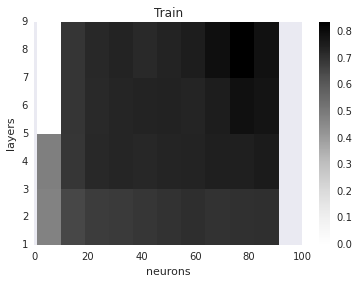

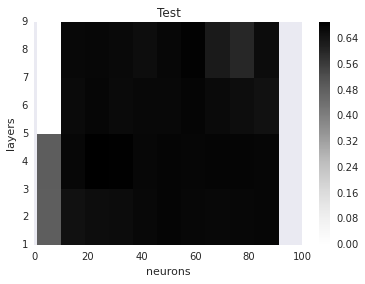

R2 for test : 0.692794463282


In [43]:
NN_achitecture(X_train,Y_train['num_planets'],X_test,Y_test['num_planets'],N_neurons=100, N_layers=10,s_nuerons=9,s_layers=2)

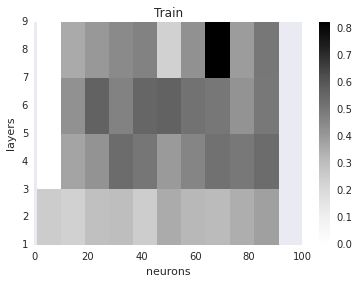

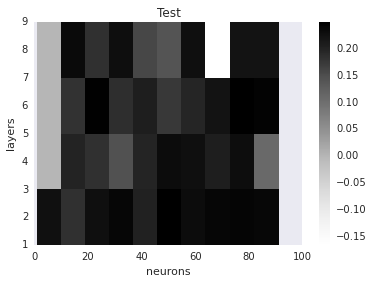

R2 for test : 0.250428368667


In [44]:
NN_achitecture(X_train,Y_train['mass_efficiency'],X_test,Y_test['mass_efficiency'],100,10,9,2)

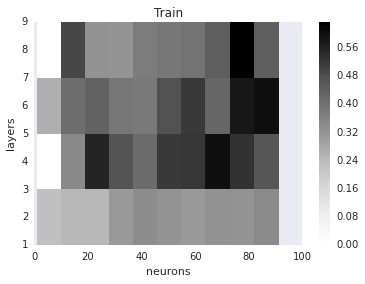

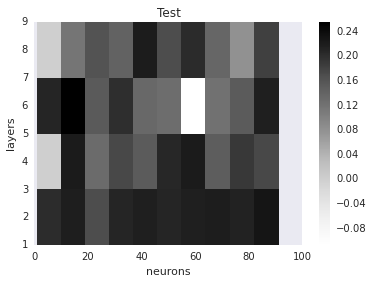

R2 for test : 0.255300096214


In [45]:
NN_achitecture(X_train,Y_train['solid_mass'],X_test,Y_test['solid_mass'],100,10,9,2)

# High and Low Segmentation

In [51]:
# Loadgin files 
folder = 'data/'
Y_high = pd.read_csv(folder+'Y_high.csv')
Y_low = pd.read_csv(folder+'Y_low.csv')

In [52]:
# Getting the statistics for original data 
ori_mean_planets = np.mean(Y_high['num_planets']) - np.mean(Y_low['num_planets'])
ori_mean_mass = np.mean(Y_high['solid_mass']) - np.mean(Y_low['solid_mass'])
ori_mean_efficiency = np.mean(Y_high['mass_efficiency']) - np.mean(Y_low['mass_efficiency'])
print('Difference between High and Low Data Sets')
print('Number of planets : ' + str(ori_mean_planets))
print('Solid mass :        ' + str(ori_mean_mass))
print('Mass efficiency :   ' + str(ori_mean_efficiency))

Difference between High and Low Data Sets
Number of planets : 0.086578580904
Solid mass :        -23.2595449429
Mass efficiency :   -70.8015582677


In [53]:
# Merge of data sets
Y_join = Y_high.append(Y_low)

In [54]:
# Simulate 
N = 50000

mass_mean = np.zeros((N,1))
efficiency_mean = np.zeros((N,1))
planets_mean = np.zeros((N,1))

for i in range(0,N):
    labels = np.concatenate((np.zeros(len(Y_low.index)), np.ones(len(Y_high.index))),axis=0)
    np.random.shuffle(labels)
        
    mass_mean[i] = np.mean(Y_join[labels==1]['solid_mass']) - np.mean(Y_join[labels==0]['solid_mass'])
    efficiency_mean[i] = np.mean(Y_join[labels==1]['mass_efficiency']) - np.mean(Y_join[labels==0]['mass_efficiency'])
    planets_mean[i] = np.mean(Y_join[labels==1]['num_planets']) - np.mean(Y_join[labels==0]['num_planets'])

In [55]:
def compare_statistics(values,base,ori_stat,alpha = 0.05):
    area_total = sum(values*(base[1:]-base[0:-1]))
    if ori_stat > 0:
        area_statistic = sum(values[base[1:]>ori_stat] * (base[1:]-base[0:-1])[base[1:]>ori_stat])/area_total
    else:
        area_statistic = sum(values[base[1:]<ori_stat] * (base[1:]-base[0:-1])[base[1:]<ori_stat])/area_total
    print('Area total                 = ' + str(1.0))
    print('Area statistic (shuffling) = ' + str(area_statistic))
    print('Area p_value               = ' + str(alpha))

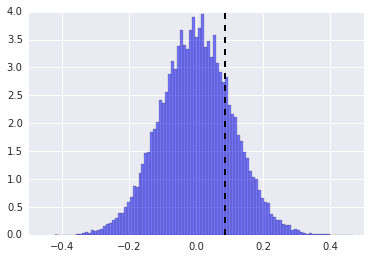

In [56]:
n, bins, patches = plt.hist(planets_mean, bins =100, normed=1.0, facecolor='blue', alpha=0.5)
values, base = np.histogram(planets_mean, bins = 100)
plt.axvline(ori_mean_planets, color='k', linestyle='dashed', linewidth=2)

In [57]:
compare_statistics(values,base,ori_mean_planets,alpha = 0.05)

Area total                 = 1.0
Area statistic (shuffling) = 0.21254
Area p_value               = 0.05


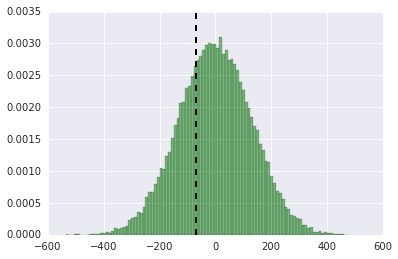

In [58]:
n, bins, patches = plt.hist(efficiency_mean, bins =100, normed=1.0, facecolor='green', alpha=0.5)
values, base = np.histogram(efficiency_mean, bins = 100)
plt.axvline(ori_mean_efficiency, color='k', linestyle='dashed', linewidth=2)

In [59]:
compare_statistics(values,base,ori_mean_efficiency,alpha = 0.05)

Area total                 = 1.0
Area statistic (shuffling) = 0.27754
Area p_value               = 0.05


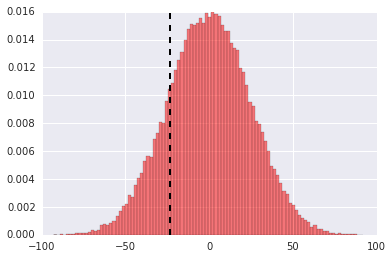

In [60]:
n, bins, patches = plt.hist(mass_mean, bins =100, normed=1.0, facecolor='red', alpha=0.5)
values, base = np.histogram(mass_mean, bins = 100)
plt.axvline(ori_mean_mass, color='k', linestyle='dashed', linewidth=2)

In [61]:
compare_statistics(values,base,ori_mean_mass,alpha = 0.05)

Area total                 = 1.0
Area statistic (shuffling) = 0.1611
Area p_value               = 0.05


# Conclusion
1. To reproduce the number of planets in a solar system, the best option is to use a neural network (R2=0.693), but polynomial regressions (order 2 or 3) also offer fair predictions (R2~0.60).
2. To reproduce the total mass of a solar system, the best option is to generate several classes and to classify the elements using random forests (hits ~43%). Otherwise, a neural network may also offer suitable results (R2=0.250).
3. To reproduce the mass efficiency of a solar system, the best option is to use a neural network (R2=0.256). Otherwise, it's possible to generate several classes and classify the elements using a random forest (hits ~23%).
4. The parameters with a biggest impact on the number of planets are:
    a. Iteration index 
    b. Disk mass
    c. Gas dissipation timescale
    d. Stellar mass
5. The parameters with a biggest impact on the total mass are:
    a. Maximum dust surface  
    b. Disk mass
    c. Metallicity wrt solar
    d. Toomre Q at min radius
6. The parameters with a biggest impact on the mass efficiency are:
    a. Maximum dust surface density 
    b. Metallicity wrt solar
    c. Iteration index
7. Based on the "High and Low Segmentation" section, the hiphotesis to probe were:

        Ho: 'There is not difference between sets'
        RHo: 'There is difference between sets'

        In all variables we can't reject the hypothesis null with a least 5 % of significance. We can say that there is a statistical difference between sets.